In [2]:
import pandas as pd
import numpy as np
from scipy.stats import skew



In [3]:
train = pd.read_csv("train_filled.csv")

In [11]:

# Step 1: Drop ID and target column, keep only numeric features
numeric_feats = train.drop(columns=["Id", "SalePrice"]).select_dtypes(include="number")

# Step 2: Remove engineered binary flags like *_missing
filtered_feats = [col for col in numeric_feats.columns if "_missing" not in col and "_flag" not in col]

# Step 3: Compute skewness for each column and filter those with skew > 2
skewed_feats = {}
for col in filtered_feats:
    values = train[col].dropna()
    if values.nunique() > 1:
        try:
            s = skew(values)
            if s > 2:
                skewed_feats[col] = s
        except:
            pass  # Skip features that cause errors in skew()

# Step 4: Print skewed features vertically, sorted by skewness
print("Skewed Features (skew > 2):\n")
for col, val in sorted(skewed_feats.items(), key=lambda x: x[1], reverse=True):
    print(f"{col:<15}: {val:.2f}")

Skewed Features (skew > 2):

MiscVal        : 24.45
PoolArea       : 14.81
LotArea        : 12.20
3SsnPorch      : 10.29
LowQualFinSF   : 9.00
KitchenAbvGr   : 4.48
BsmtFinSF2     : 4.25
ScreenPorch    : 4.12
BsmtHalfBath   : 4.10
EnclosedPorch  : 3.09
MasVnrArea     : 2.67
OpenPorchSF    : 2.36
LotFrontage    : 2.21


In [13]:
# Step 4: Display summary stats and value distribution for each skewed feature
for feat in sorted(skewed_feats, key=skewed_feats.get, reverse=True):
    print(f"Feature: {feat} — Skewness: {skewed_feats[feat]:.2f}")
    
    # Summary statistics
    print(train[feat].describe())
    
    # Full value distribution
    print(train[feat].value_counts().sort_index())


Feature: MiscVal — Skewness: 24.45
count     1460.000000
mean        43.489041
std        496.123024
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      15500.000000
Name: MiscVal, dtype: float64
MiscVal
0        1408
54          1
350         1
400        11
450         4
480         2
500         8
560         1
600         4
620         1
700         5
800         1
1150        1
1200        2
1300        1
1400        1
2000        4
2500        1
3500        1
8300        1
15500       1
Name: count, dtype: int64
Feature: PoolArea — Skewness: 14.81
count    1460.000000
mean        2.758904
std        40.177307
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       738.000000
Name: PoolArea, dtype: float64
PoolArea
0      1453
480       1
512       1
519       1
555       1
576       1
648       1
738       1
Name: count, dtype: int64
Feature: LotArea — Skewness: 12.20
count      1460.000000
mean   

In [14]:
# --- Group A: Binary flags for sparse features ---
group_a = ['MiscVal', 'PoolArea', '3SsnPorch', 'LowQualFinSF', 'ScreenPorch', 'BsmtFinSF2']
for col in group_a:
    train[f'{col}_flag'] = (train[col] > 0).astype(int)

# --- Group B: Log-transform long-tailed features ---
group_b = ['LotArea', 'OpenPorchSF', 'LotFrontage', 'MasVnrArea', 'EnclosedPorch']
for col in group_b:
    train[f'{col}_log'] = np.log1p(train[col])

# --- Group C: Leave as-is ---
group_c = ['KitchenAbvGr', 'BsmtHalfBath']  # no changes applied


In [15]:
#Final check 
train[[f'{col}_flag' for col in group_a] + [f'{col}_log' for col in group_b]].head()


,MiscVal_flag,PoolArea_flag,3SsnPorch_flag,LowQualFinSF_flag,ScreenPorch_flag,BsmtFinSF2_flag,LotArea_log,OpenPorchSF_log,LotFrontage_log,MasVnrArea_log,EnclosedPorch_log
0,0,0,0,0,0,0,9.042040,4.127134,4.189655,5.283204,0.000000
1,0,0,0,0,0,0,9.169623,0.000000,4.394449,0.000000,0.000000
2,0,0,0,0,0,0,9.328212,3.761200,4.234107,5.093750,0.000000
3,0,0,0,0,0,0,9.164401,3.583519,4.110874,0.000000,5.609472
4,0,0,0,0,0,0,9.565284,4.442651,4.442651,5.860786,0.000000


In [16]:
# Check how many 1s are in each *_flag column
train[[f'{col}_flag' for col in group_a]].sum()

MiscVal_flag          52
PoolArea_flag          7
3SsnPorch_flag        24
LowQualFinSF_flag     26
ScreenPorch_flag     116
BsmtFinSF2_flag      167
dtype: int64

In [17]:
train.to_csv("train_with_engineered_features_Refined.csv", index=False)

In [18]:
# Raw + Engineered feature list
raw_features = ['MiscVal', 'PoolArea', '3SsnPorch', 'LowQualFinSF', 'ScreenPorch', 'BsmtFinSF2',
                'LotArea', 'OpenPorchSF', 'LotFrontage', 'MasVnrArea', 'EnclosedPorch']
engineered_features = [f'{col}_flag' for col in raw_features[:6]] + [f'{col}_log' for col in raw_features[6:]]

# Combine with target
features_to_check = raw_features + engineered_features + ['SalePrice']

# Compute Pearson correlations with SalePrice
correlations = train[features_to_check].corr()['SalePrice'].sort_values(ascending=False)
print(correlations)


SalePrice            1.000000
MasVnrArea           0.472614
OpenPorchSF_log      0.429970
MasVnrArea_log       0.405162
LotArea_log          0.388528
LotFrontage          0.349876
LotFrontage_log      0.345253
OpenPorchSF          0.315856
LotArea              0.263843
ScreenPorch          0.111447
PoolArea_flag        0.093708
PoolArea             0.092404
ScreenPorch_flag     0.087143
3SsnPorch_flag       0.046015
3SsnPorch            0.044584
BsmtFinSF2          -0.011378
MiscVal             -0.021190
LowQualFinSF        -0.025606
LowQualFinSF_flag   -0.047932
BsmtFinSF2_flag     -0.052965
MiscVal_flag        -0.068374
EnclosedPorch       -0.128578
EnclosedPorch_log   -0.176065
Name: SalePrice, dtype: float64


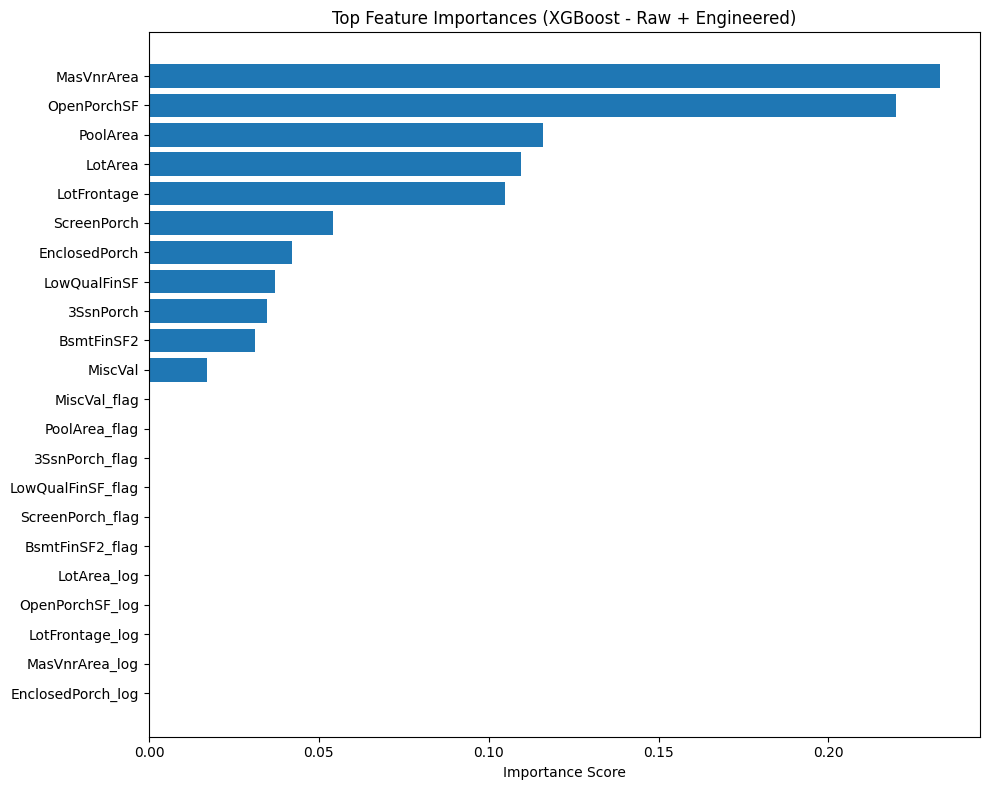

In [19]:
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# Combine into full feature set
X_final = train[raw_features + engineered_features]
y_final = train['SalePrice']

# Train XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_final, y_final)

# Get feature importances
importance_df = pd.DataFrame({
    'Feature': X_final.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel("Importance Score")
plt.title("Top Feature Importances (XGBoost - Raw + Engineered)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()